In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from lr.text_processing.util import pre_process_nli_df, get_vocab_count
from lr.text_processing.transformations.util import syn_h2tranformation, syn_p2tranformation
from lr.text_processing.transformations.util import syn2tranformation
from lr.text_processing.transformations.util import get_augmented_data
from lr.text_processing.transformations.structural import invert, entailment_internalization
from lr.training.util import get_binary_label, get_ternary_label
from lr.training.language_representation import Tfidf
from lr.training.util import filter_df_by_label
from lr.models.logistic_regression import LRWrapper
from lr.stats.matched_comparison import get_disagreement_statistics
from IPython.display import HTML, display

# load data

In [2]:
train_path = "data/snli/train.csv"
dev_path = "data/snli/dev.csv"
result_path = "results/snli_lr_Tfidf_invert.csv"
debug = False

df = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)

if debug:
    df = df.head(1000)
    dev = dev.head(1000)

df = filter_df_by_label(df.dropna()).reset_index(drop=True)
dev = filter_df_by_label(dev.dropna()).reset_index(drop=True)

pre_process_nli_df(df)
pre_process_nli_df(dev)

## Creating lexical masking

In [3]:
head = 800
mwords = 300

c = get_vocab_count(df.head(head))
mask = {i[0]: "" for i in c.most_common(mwords)}

# get pct x t

In [107]:
trials = 3
max_features = None

label_translation = get_ternary_label
# label_translation = get_binary_label

# transformation = syn2tranformation(mask)
# transformation = syn_h2tranformation(mask)
transformation = invert
# transformation = entailment_internalization
# transformation = syn_p2tranformation(mask)

dev_t = get_augmented_data(df=dev,
                           transformation=transformation,
                           frac=1)


pcts = np.linspace(0, 1, trials)
stats = []



hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

for pct in tqdm(pcts):

    aug = get_augmented_data(df=df,
                             transformation=transformation,
                             frac=pct)

    lr = LRWrapper(hyperparams)
    lr.fit(aug)


    st = get_disagreement_statistics(df=dev,
                                     df_t=dev_t,
                                     model=lr,
                                     label_translation=label_translation)

    stats.append(st)
    del lr, aug
    
result = pd.concat(stats)
result.index = pcts
result.index.name = "pcts"

  0%|          | 0/3 [00:00<?, ?it/s]/home/felsal/lr/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 33%|███▎      | 1/3 [00:40<01:21, 40.53s/it]/home/felsal/lr/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver

## Plots

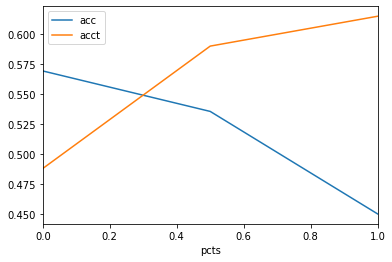

In [108]:
result[["acc", 'acct']].plot();

In [6]:
result.to_csv(result_path)

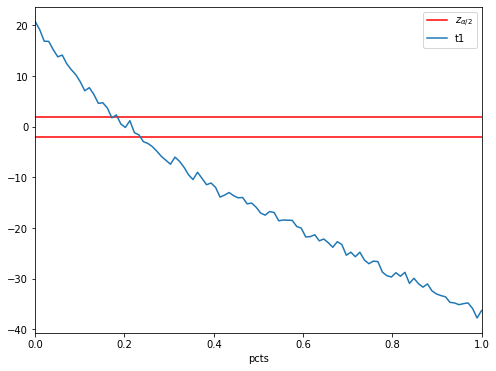

In [7]:
alpha = 0.05
z_alpha_2 =  scipy.stats.norm.ppf(1  - (alpha/2))
paired_t_reject_H0 = result.t1.apply(np.abs) > z_alpha_2
paired_t_reject_H0 = paired_t_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
paired_t_reject_H0.name = "paired_t"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=z_alpha_2, color='r', linestyle='-', label=r"$z_{\alpha/2}$")
plt.axhline(y=-z_alpha_2, color='r', linestyle='-')
result[["t1"]].plot(ax=ax);
plt.legend(loc="best");

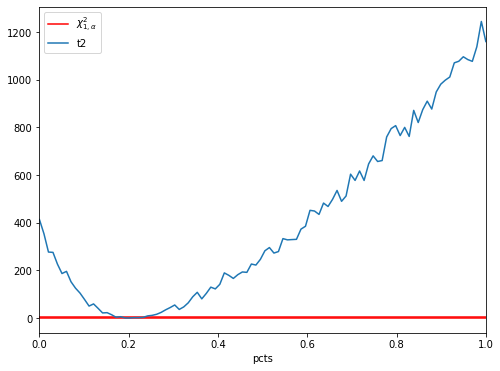

In [8]:
chi_2_alpha =  scipy.stats.chi2.ppf(1 - alpha, df=1)
cochran_reject_H0 = result.t2 > chi_2_alpha
cochran_reject_H0 = cochran_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
cochran_reject_H0.name = "cochran"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=chi_2_alpha, color='r', linestyle='-', label=r"$\chi^{2}_{1,\alpha}$")
plt.axhline(y=0, color='r', linestyle='-')
result[["t2"]].plot(ax=ax);
plt.legend(loc="best");

## Tests
### basic info

In [9]:
tests = pd.DataFrame([paired_t_reject_H0, cochran_reject_H0]).transpose()
disagreement = tests[~ (tests.cochran == tests.paired_t)]
display(HTML(tests.cochran.value_counts().to_frame().to_html()))
display(HTML(tests.paired_t.value_counts().to_frame().to_html()))
display(HTML(disagreement.to_html()))

,cochran
reject H0,94
retain H0,6


,paired_t
reject H0,94
retain H0,6


,paired_t,cochran
pcts,,


### p-values

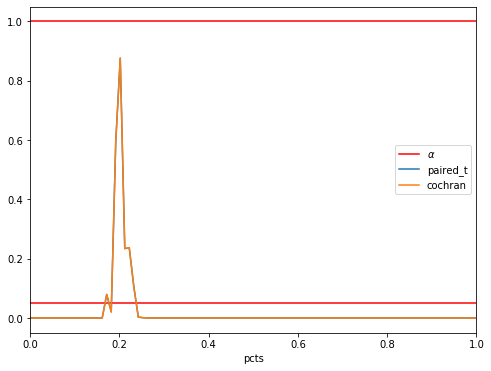

In [10]:
p_normal = lambda x: 2*scipy.stats.norm.cdf(- np.abs(x))
p_chi2 = lambda x: 1 - scipy.stats.chi2.cdf(x,df=1)
p_t1 = result.t1.map(p_normal)
p_t1.name = "paired_t"
p_t2 = result.t2.map(p_chi2)
p_t2.name = "cochran"
p_values = pd.DataFrame([p_t1, p_t2]).transpose()

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=alpha, color='r', linestyle='-', label=r"$\alpha$")
p_values.plot(ax=ax);
plt.legend(loc="best");

In [14]:
dev.head()

,premise,hypothesis,label
0,two women are embracing while holding to go pa...,the sisters are hugging goodbye while holding ...,neutral
1,two women are embracing while holding to go pa...,two woman are holding packages,entailment
2,two women are embracing while holding to go pa...,the men are fighting outside a deli,contradiction
3,two young children in blue jerseys one with th...,two kids in numbered jerseys wash their hands,entailment
4,two young children in blue jerseys one with th...,two kids at a ballgame wash their hands,neutral


In [15]:
dev_t.head()

,premise,hypothesis,label
0,the sisters are hugging goodbye while holding ...,two women are embracing while holding to go pa...,neutral
1,two women are embracing while holding to go pa...,two woman are holding packages,entailment
2,the men are fighting outside a deli,two women are embracing while holding to go pa...,contradiction
3,two young children in blue jerseys one with th...,two kids in numbered jerseys wash their hands,entailment
4,two kids at a ballgame wash their hands,two young children in blue jerseys one with th...,neutral


In [98]:
from lr.training.language_representation import BOW

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": 50,
               "num_words": 50,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}


aug = get_augmented_data(df=df,
                         transformation=transformation,
                         frac=0.5)

lr = LRWrapper(hyperparams)
lr.fit(aug)

In [99]:
def get_corpus(df):
    """
    get corpus from NLI dataset

    :param df: NLI df
    :type df: pd.DataFrame
    :return: corpus, list of sentences
    :rtype: [str]
    """
    corpus = df.premise + " " + df.hypothesis
    return list(corpus.values)

In [100]:

corpus1 = get_corpus(dev.head(1))
a = lr.repr.transform(corpus1).toarray()
corpus2 = get_corpus(dev_t.head(1))
b = lr.repr.transform(corpus2).toarray()

In [101]:
a

array([[0.        , 0.        , 0.33163317, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.57590028,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.12263471, 0.        , 0.402402  ,
        0.22316447, 0.        , 0.        , 0.        , 0.49019472,
        0.        , 0.        , 0.        , 0.30215628, 0.        ]])

In [102]:
b

array([[0.        , 0.        , 0.33163317, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.57590028,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.12263471, 0.        , 0.402402  ,
        0.22316447, 0.        , 0.        , 0.        , 0.49019472,
        0.        , 0.        , 0.        , 0.30215628, 0.        ]])

In [103]:
vocab = {v: k for k, v in lr.repr.vocab.items()}

In [106]:
a == b

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]])

In [105]:
ca = []

for i, j in enumerate(a[0]):
    ca+=[vocab[i]] * j
    
cb = []

for i, j in enumerate(b[0]):
    cb+=[vocab[i]] * j

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
ca

In [ ]:
cb

In [ ]:
corpus1

In [ ]:
corpus2

In [41]:
a[1]  == b[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [42]:
lr.repr.vocab

{'person': 30,
 'on': 26,
 'down': 12,
 'is': 21,
 'his': 18,
 'for': 13,
 'at': 4,
 'an': 0,
 'children': 10,
 'and': 1,
 'are': 2,
 'their': 38,
 'the': 37,
 'boy': 7,
 'in': 20,
 'of': 25,
 'red': 32,
 'wearing': 43,
 'man': 23,
 'as': 3,
 'to': 39,
 'with': 46,
 'while': 44,
 'women': 48,
 'one': 27,
 'two': 40,
 'people': 29,
 'sitting': 34,
 'shirt': 33,
 'woman': 47,
 'holding': 19,
 'playing': 31,
 'outside': 28,
 'by': 8,
 'child': 9,
 'young': 49,
 'girl': 15,
 'standing': 35,
 'street': 36,
 'front': 14,
 'walking': 42,
 'her': 17,
 'looking': 22,
 'white': 45,
 'black': 5,
 'dog': 11,
 'blue': 6,
 'up': 41,
 'group': 16,
 'men': 24}